# **SMU Course Bidding Data Preprocessing using CatBoost V1**

<div style="background-color:#FFDDC1; padding:15px; border-radius:5px; border: 2px solid #FF5733;">
    
  <h1 style="color:#D8000C;">⚠️🚨 DEPRECATED: USE V3 INSTEAD 🚨⚠️</h1>
  
  <p><strong>❌ This version (V1) is NO LONGER MAINTAINED</strong></p>
  <p><strong>✅ The latest <code>.cbm</code> model has been published, and V3 is now recommended.</strong></p>

  <h3>🔥 Why should you use V3 instead?</h3>
  <ul>
    <li>✔️ <strong>More accurate predictions</strong> 🏆</li>
    <li>✔️ <strong>Better feature selection & training</strong> 🎯</li>
    <li>✔️ <strong>Refined safety factors for optimal results</strong> 📊</li>
  </ul>

  <h3>🔗 📌 Recommendation:</h3>
  <p>👉 <a href="example_prediction.ipynb"><strong>Switch to V3 example_prediction.ipynb for the best performance!</strong> 🚀</a></p>
</div>

### **Difference between V1 and V2**
- V1: Using readily available BOSS data found on OASIS.
- V2: Using scraped data from BOSS Bidding website on class and exam timings, locations, and grading basis.

### **Objective**
This notebook performs the following steps:
1. **Data Cleaning** - Handle redundant columns and remove unwanted data.
2. **Feature Engineering** - Create derived features.
3. **Exploratory Data Analysis (EDA)** - Analyze key features and correlations.
4. **Further Data Cleaning** - Removing high multicollinear variables.
5. **Save Processed Data** - Save the data into a csv that is useable for other ML models

### **Requirements**
- Python 3.x
- TensorFlow, Pandas, NumPy, Matplotlib, Seaborn, Sklearn
- Currently available excel sheets on SMU Oasis for overall boss bidding results

---

In [2]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Set up folder path containing all Excel files
data_folder = 'overallBossResults'
data_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.xls')]

# Load and combine data
dataframes = [pd.read_excel(file) for file in data_files]
data = pd.concat(dataframes, ignore_index=True)

# Basic data checks
print(f"Loaded {len(data_files)} files.")
print("Initial Data Shape:", data.shape)
print(data.head())

Loaded 12 files.
Initial Data Shape: (121221, 16)
             Term                   Session     Bidding Window Course Code  \
0  2021-22 Term 2  Regular Academic Session  Round 2A Window 3     ACCT001   
1  2021-22 Term 2  Regular Academic Session  Round 2A Window 3     ACCT009   
2  2021-22 Term 2  Regular Academic Session  Round 2A Window 3     ACCT101   
3  2021-22 Term 2  Regular Academic Session  Round 2A Window 3     ACCT101   
4  2021-22 Term 2  Regular Academic Session  Round 2A Window 3     ACCT101   

                                         Description Section  Vacancy  \
0  Accounting Study Mission (Asian Studies)(Bangkok)      G1       45   
1  Overseas Project Experience (Accounting in Asi...      G1       25   
2                               Financial Accounting      G1       42   
3                               Financial Accounting     G10       45   
4                               Financial Accounting     G11       45   

   Opening Vacancy  Before Process Vacancy


---
## 1. Data Cleaning

Steps:
1. Remove rows where 'Min Bid' is 0.
2. Drop redundant columns and future based information:
    - `Session`
    - `D.I.C.E`
    - `School/Department`
    - `Opening Vacancy`
3. Handle missing values (if any).
    

In [4]:
# Data Cleaning
# 1. Remove rows where 'Min Bid' == 0
data = data[data['Min Bid'] != 0]

# 2. Drop redundant columns
columns_to_drop = ['Session', 'D.I.C.E', 'School/Department', 'Opening Vacancy']
data = data.drop(columns=columns_to_drop, errors='ignore')

# 3. Handle missing values
data['Instructor'] = data['Instructor'].fillna("Not Assigned Yet")


---
## 2. Feature Engineering

Steps:
1. Create `AY` and `Term` columns from `Term` column.
2. Transform `Bidding Window` into `Round` and `Window`.
3. Split `Course Code` into `SubjectArea` and `CatalogueNo`.
4. Label encode for categorical columns:
    - `Description`, `SubjectArea`, `Section`, `Instructor`
5. Create derived columns:
    - `BidderCount`: `Before Process Vacancy` - `After Process Vacancy`
    - `CurrEnrolledCount`: `Enrolled Students` - `BidderCount`
    

In [5]:
# Feature Engineering
# Extract AY and Term
data['AY'] = data['Term'].str[:4]
data['Term'] = data['Term'].str.split('Term ', expand=True)[1].str.strip()

# Extract Round and Window from 'Bidding Window'
data['Round'] = data['Bidding Window'].str.extract(r'Round (\d[A-B]?)')
data['Window'] = data['Bidding Window'].str.extract(r'Window (\d)')

# Extract SubjectArea and CatalogueNo from 'Course Code'
data['SubjectArea'] = data['Course Code'].str.extract(r'([A-Za-z-]+)')
data['CatalogueNo'] = data['Course Code'].str.extract(r'(\d+)$')

# Create BidderCount and CurrEnrolledCount
data['BidderCount'] = data['Before Process Vacancy'] - data['After Process Vacancy']
data['CurrEnrolledCount'] = data['Enrolled Students'] - data['BidderCount']

# Drop columns used for derived features
data = data.drop(columns=['Bidding Window', 'Course Code', 'Before Process Vacancy', 
                          'After Process Vacancy', 'Enrolled Students'], errors='ignore')

# After extracting AY and Window from strings, convert them to numeric
data['AY'] = pd.to_numeric(data['AY'], errors='coerce')
data['Window'] = pd.to_numeric(data['Window'], errors='coerce')

# Round 2A has no window, thus has to be assigned -1
data['Window'] = data['Window'].fillna(-1).astype(int)

# Manual mapping for Term
# Term dropdown: 1, 2, 3A, 3B
term_map = {
    '1': 1,
    '2': 2,
    '3A': 3,
    '3B': 4
}

data['Term'] = data['Term'].map(term_map)

# Manual mapping for Round
# Round dropdown: 1, 1A, 1B, 1C, 2, 2A
round_map = {
    '1': 1,
    '1A': 2,
    '1B': 3,
    '1C': 4,
    '2': 5,
    '2A': 6
}

data['Round'] = data['Round'].map(round_map)

data.dropna(subset=['Round'],inplace=True)

print("Data after Cleaning and Feature Engineering:")
print(data.head())
print(data.info())

Data after Cleaning and Feature Engineering:
    Term                       Description Section  Vacancy  Median Bid  \
45     2  Financial Reporting and Analysis      G3       42       25.00   
64     2                         Valuation      G1       42       10.09   
65     2                         Valuation      G2       42       10.03   
73     2    Auditing for the Public Sector      G1       42       25.00   
96     2          Public Relations Writing      G1       45       10.00   

    Min Bid            Instructor    AY  Round  Window SubjectArea  \
45    25.00          GOH BENG WEE  2021    6.0       3        ACCT   
64    10.09        CHENG NAM SANG  2021    6.0       3        ACCT   
65    10.00        CHENG NAM SANG  2021    6.0       3        ACCT   
73    25.00          LIM SOO PING  2021    6.0       3        ACCT   
96    10.00   YASMIN HANNAH RAMLE  2021    6.0       3        COMM   

   CatalogueNo  BidderCount  CurrEnrolledCount  
45         224            1       


---
## 3. Exploratory Data Analysis (EDA)

### Steps:
1. Explore statistics and distributions of all variables.
2. Perform corrleation heatmap on numerical variables. Perform feature selection afterwards to remove high multicollinear variables.


### Descriptive statistics

In [6]:
# 1. Print descriptive statistics for all columns
print("=== Descriptive Statistics (All Columns) ===")
display(data.describe(include='all'))

=== Descriptive Statistics (All Columns) ===


,Term,Description,Section,Vacancy,Median Bid,Min Bid,Instructor,AY,Round,Window,SubjectArea,CatalogueNo,BidderCount,CurrEnrolledCount
count,31601.000000,31601,31601,31601.000000,31601.000000,31601.000000,31601,31601.000000,31601.000000,31601.000000,31601,31601,31601.000000,31601.000000
unique,NaN,666,45,NaN,NaN,NaN,930,NaN,NaN,NaN,55,373,NaN,NaN
top,NaN,Management Communication,G1,NaN,NaN,NaN,Not Assigned Yet,NaN,NaN,NaN,COR,101,NaN,NaN
freq,NaN,1129,12283,NaN,NaN,NaN,512,NaN,NaN,NaN,4734,2431,NaN,NaN
mean,1.576880,NaN,NaN,43.705168,29.774240,24.992186,NaN,2022.612069,2.657542,1.501218,NaN,NaN,6.710705,25.599063
std,0.502194,NaN,NaN,43.300971,21.471416,20.425339,NaN,1.020166,1.596197,0.626276,NaN,NaN,10.105866,15.765639
min,1.000000,NaN,NaN,1.000000,10.000000,10.000000,NaN,2021.000000,1.000000,1.000000,NaN,NaN,-2.000000,-2.000000
25%,1.000000,NaN,NaN,45.000000,15.000000,10.110000,NaN,2022.000000,1.000000,1.000000,NaN,NaN,1.000000,12.000000
50%,2.000000,NaN,NaN,45.000000,24.950000,17.890000,NaN,2023.000000,2.000000,1.000000,NaN,NaN,2.000000,31.000000
75%,2.000000,NaN,NaN,45.000000,37.950000,32.040000,NaN,2023.000000,3.000000,2.000000,NaN,NaN,6.000000,39.000000


### Outlier fixing

1. There are three rows affected with vacancy of 4445. Replace with 45.

In [7]:
# Replace all rows where Vacancy is 4445 with 45
data.loc[data['Vacancy'] == 4445, 'Vacancy'] = 45

### Correlation heatmap

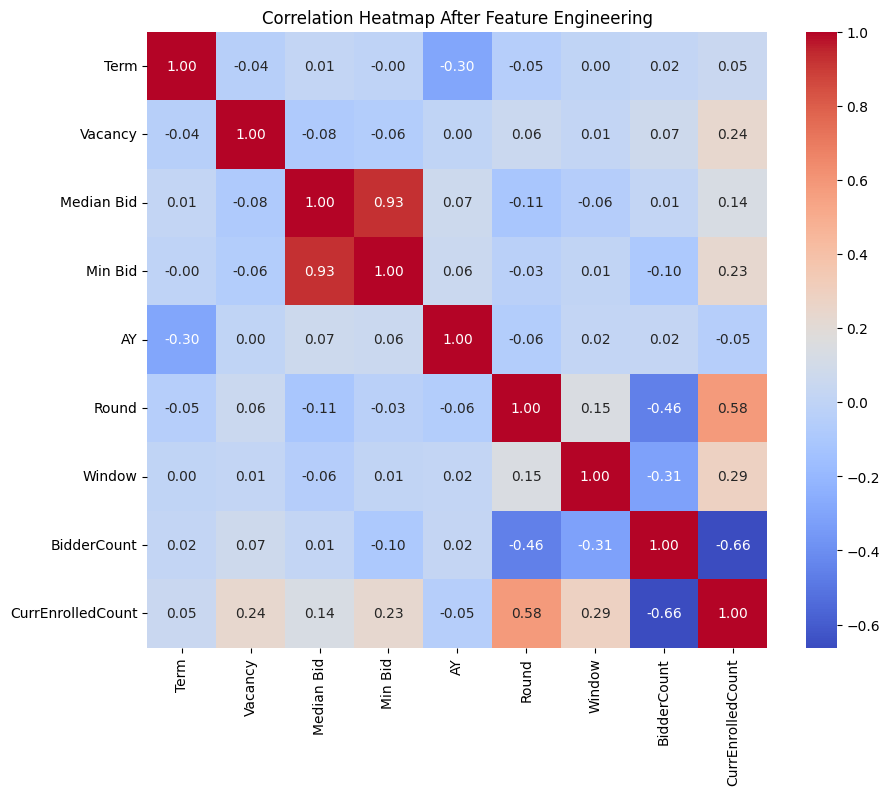

In [8]:
# Check distributions and correlations post feature engineering
corr = data.corr(numeric_only=True)
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap After Feature Engineering")
plt.show()

### Insights from Correlation Heatmap Analysis

1. MinBid and MedianBid – (0.93)
    - **Reason**: MinBid is around MedianBid when bidder count is low (1-3 people).
    - **Action**: Remove MedianBid since it’s redundant in this case.

2. BidderCount and CurrEnrolledCount (-0.67)
    - **Reason**: CurrEnrolledCount uses BidderCount as part of the formula:
        - Formula: ‘Enrolled Student’ – ‘BidderCount’.
    - **Action**: Might have to delete CurrEnrolledCount to maintain independence (avoid multicollinearity) between variables.

3. Round and CurrEnrolledCount (0.53)
    - **Reason**: CurrEnrolledCount will be higher as rounds progress, as most classes get full.
    - **Action**: CurrEnrolledCount will need to be removed as per point 2.

4. Round and BidderCount (-0.41)
    - **Reason**: As there are more rounds, there will be fewer bidders. Most students secure their spots early to prevent inflation from supply squeeze.
    - **Action**: No removal; this is a natural relationship.

5. MinBid vs CurrEnrolledCount (0.22)
    - **Reason**: If there is less CurrEnrolledCount, MinBid will be lower due to higher supply.
    - **Action**: CurrEnrolledCount will need to be removed as per point 2.

6. Round and Window (0.14)
    - **Reason**: Can't think of a good reason.
    - **Action**: No removal; this is a natural relationship.

### Interesting thing about insights vs personal intuition
1. Initially expected BidderCount to be highly negatively correlated with MinBid since having lesser people bid means lesser minimum bid prices. Data shows that this is not true.

### Correlation for categorical variables

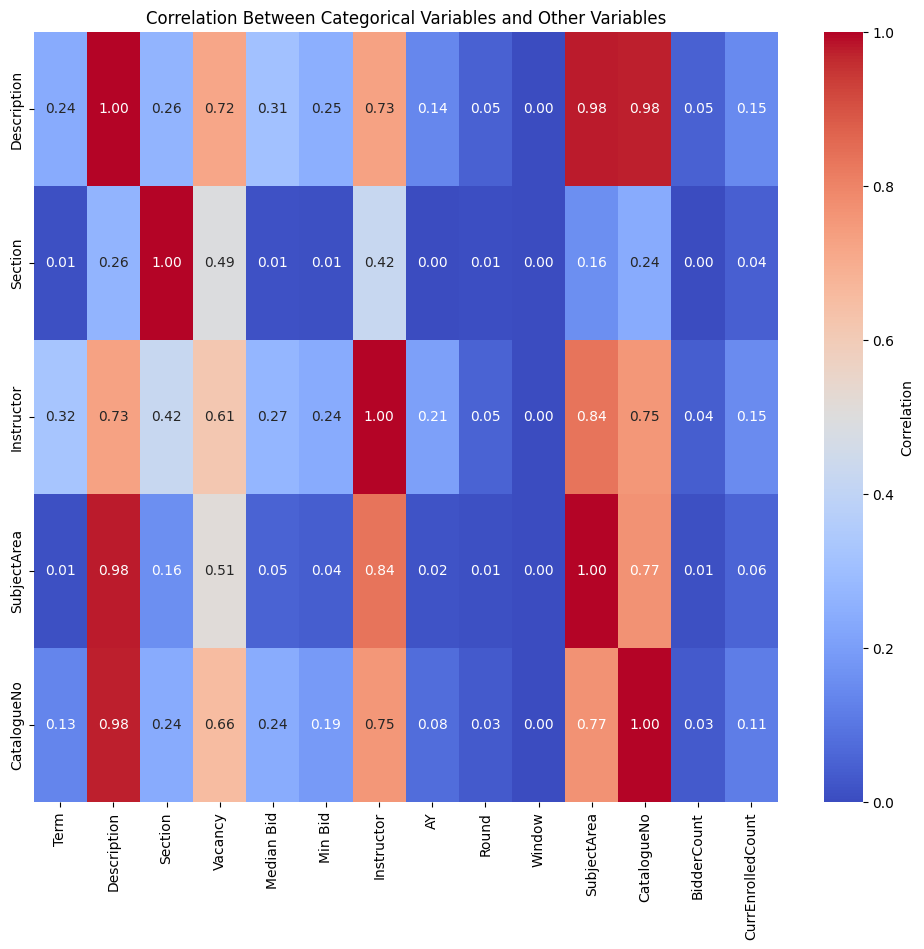

In [9]:
from scipy.stats import chi2_contingency

# Function to compute Cramér's V for categorical vs categorical variables
def cramers_v(contingency_table):
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    r, k = contingency_table.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

# Function to compute correlation ratio (η²) for categorical vs numerical
def correlation_ratio(categories, values):
    categories = pd.Categorical(categories)
    category_means = values.groupby(categories).mean()
    overall_mean = values.mean()
    ss_between = sum((category_means[categories] - overall_mean) ** 2)
    ss_total = sum((values - overall_mean) ** 2)
    return (ss_between / ss_total) if ss_total > 0 else 0

# Collect all categorical variables
categorical_vars = ['Description', 'Section', 'Instructor', 'SubjectArea', 'CatalogueNo']

# Prepare a dataframe to store the results
cat_corr_results = pd.DataFrame(index=categorical_vars, columns=data.columns)

# Compute correlation for each categorical variable against all other variables
for cat_var in categorical_vars:
    for col in data.columns:
        if data[col].dtype in ['int64', 'float64']:  # Numerical columns
            cat_corr_results.loc[cat_var, col] = correlation_ratio(data[cat_var], data[col])
        elif data[col].dtype == 'object':  # Categorical columns
            # Use Cramér's V for categorical vs categorical
            contingency_table = pd.crosstab(data[cat_var], data[col])
            cat_corr_results.loc[cat_var, col] = cramers_v(contingency_table)

# Format and display the results
cat_corr_results = cat_corr_results.fillna(0).astype(float)
plt.figure(figsize=(12, 10))
sns.heatmap(cat_corr_results, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Correlation'})
plt.title("Correlation Between Categorical Variables and Other Variables")
plt.show()

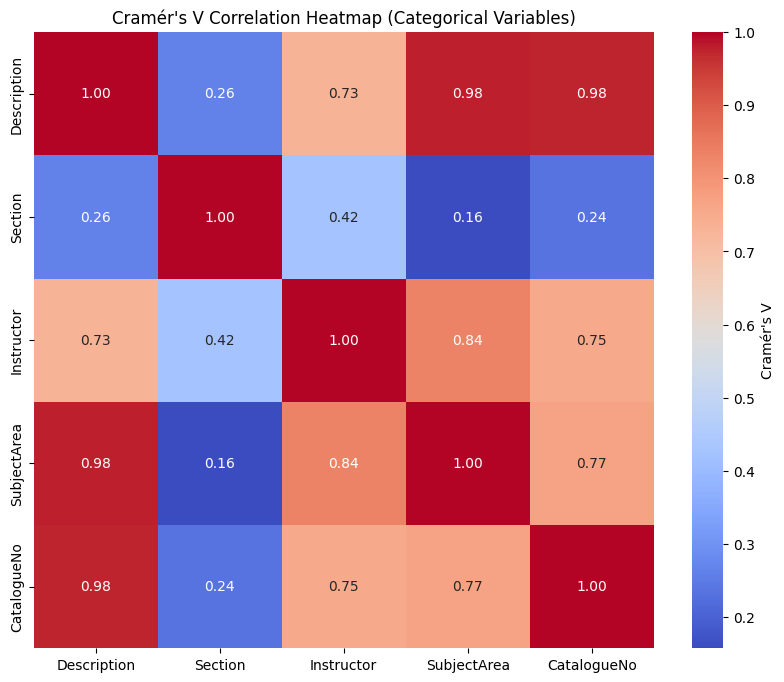

In [10]:
# Create a DataFrame to store the results
cat_corr_matrix = pd.DataFrame(index=categorical_vars, columns=categorical_vars, dtype=float)

# Compute Cramér's V for each pair of categorical variables
for var1 in categorical_vars:
    for var2 in categorical_vars:
        if var1 == var2:
            cat_corr_matrix.loc[var1, var2] = 1.0  # Perfect correlation with itself
        else:
            contingency_table = pd.crosstab(data[var1], data[var2])
            cat_corr_matrix.loc[var1, var2] = cramers_v(contingency_table)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cat_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Cramér\'s V'})
plt.title("Cramér's V Correlation Heatmap (Categorical Variables)")
plt.show()

### Univariate analysis of Min Bid

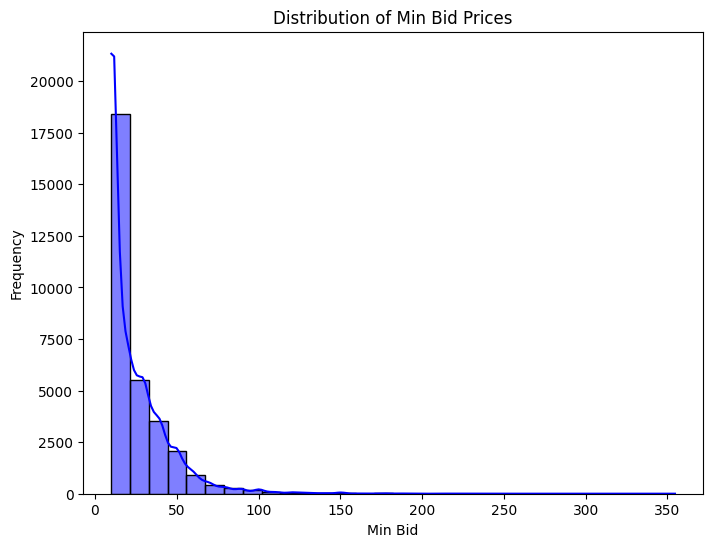

In [11]:
# Univariate analysis of Min Bid
plt.figure(figsize=(8, 6))
sns.histplot(data['Min Bid'], kde=True, bins=30, color='blue')
plt.title("Distribution of Min Bid Prices")
plt.xlabel("Min Bid")
plt.ylabel("Frequency")
plt.show()

### Bivariate analysis of Min Bid


#### AY analysis against Min Bid

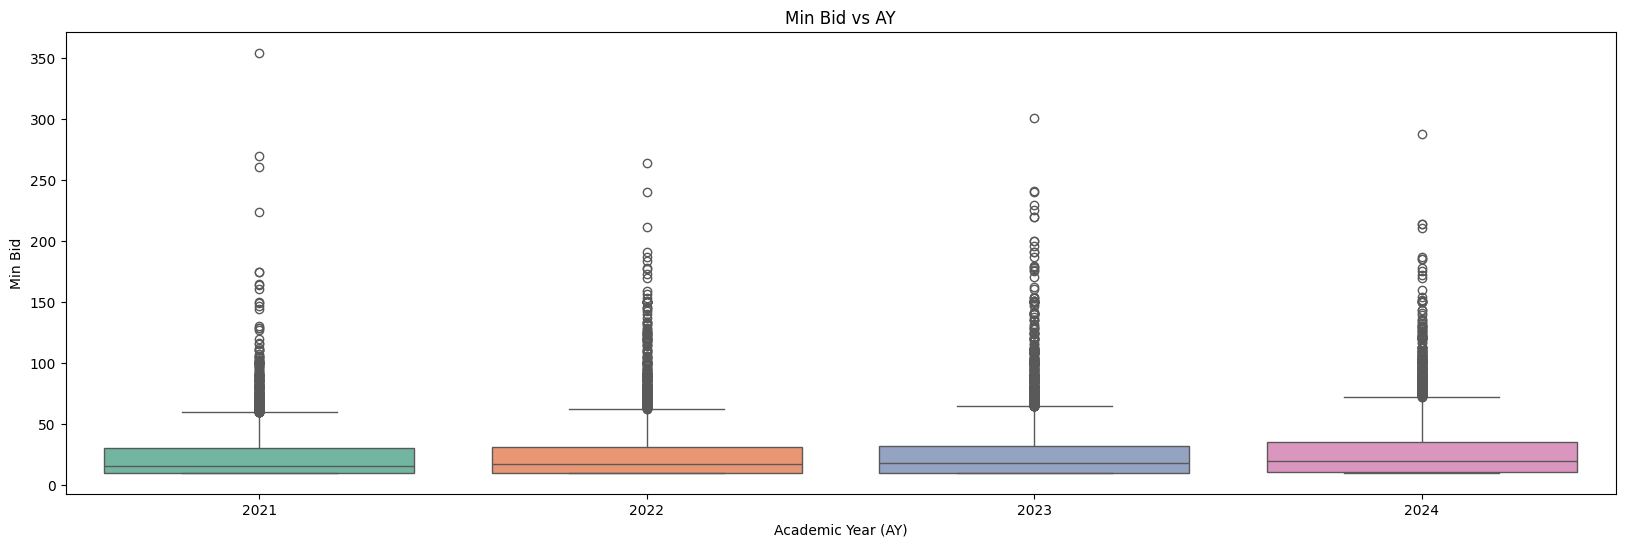

Numerical Statistics for Min Bid by AY:


,count,mean,std,min,25%,50%,75%,max
AY,,,,,,,,
2021,5098.0,23.415775,19.729822,10.0,10.030,15.585,30.00,354.58
2022,9657.0,24.304077,19.211898,10.0,10.100,17.360,31.00,263.83
2023,9252.0,25.118096,21.064273,10.0,10.100,17.920,32.01,300.99
2024,7594.0,26.772106,21.436332,10.0,10.935,20.000,35.50,288.00


In [12]:
# Boxplot for AY
plt.figure(figsize=(20, 6))
sns.boxplot(x=data['AY'], y=data['Min Bid'], palette='Set2', legend=False, hue=data['AY'])
plt.title("Min Bid vs AY")
plt.xlabel("Academic Year (AY)")
plt.ylabel("Min Bid")
plt.show()

# Numerical statistics for AY
ay_stats = data.groupby('AY')['Min Bid'].describe()
print("Numerical Statistics for Min Bid by AY:")
display(ay_stats)

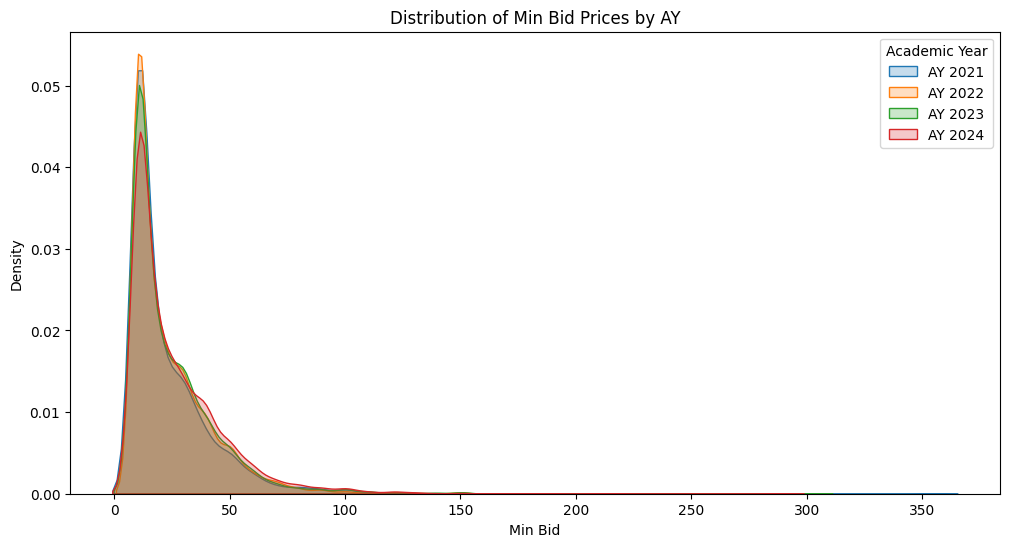

In [13]:
# KDE plot for AY
plt.figure(figsize=(12, 6))
for ay in data['AY'].unique():
    sns.kdeplot(data[data['AY'] == ay]['Min Bid'], label=f"AY {ay}", fill=True)
plt.title("Distribution of Min Bid Prices by AY")
plt.xlabel("Min Bid")
plt.ylabel("Density")
plt.legend(title="Academic Year")
plt.show()

Insights:
1. The average Min Bid Prices has been steadily increasing over the years.
2. The std of Min Bid Prices has also been increasing, suggesting more variability now.

#### Term analysis against Min Bid

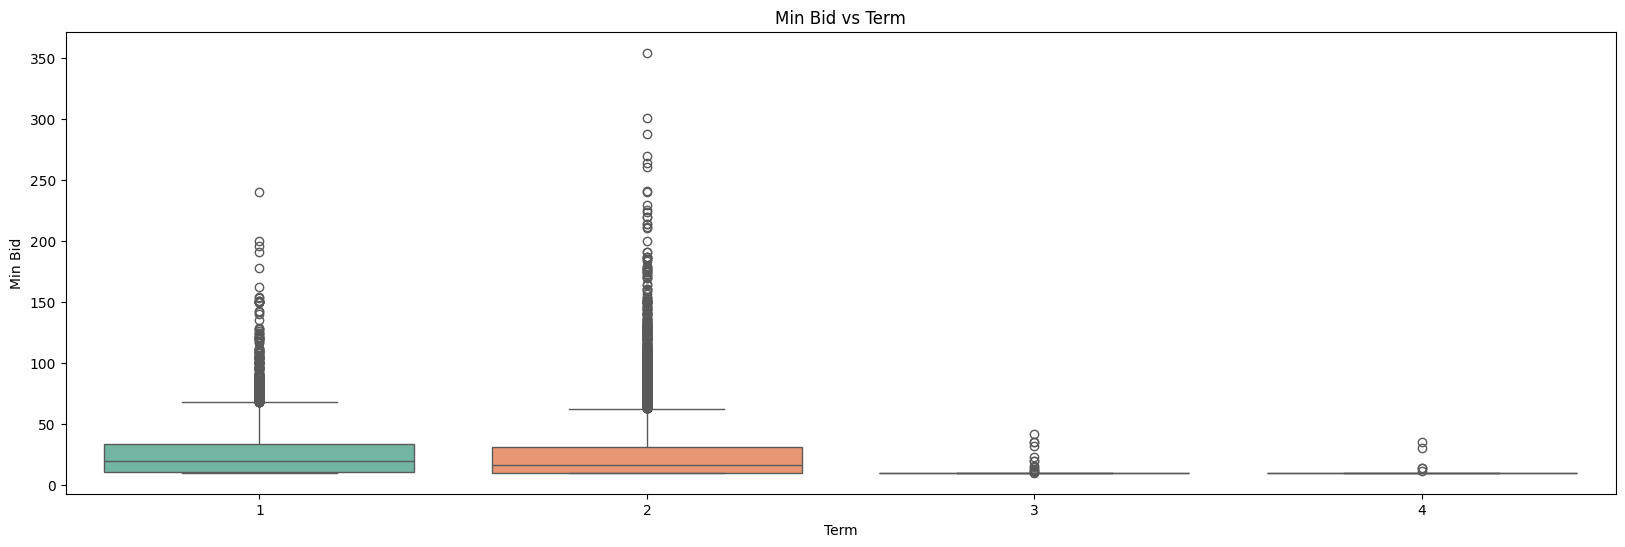

Numerical Statistics for Min Bid by Term:


,count,mean,std,min,25%,50%,75%,max
Term,,,,,,,,
1,13477.0,24.911082,17.958826,10.0,10.53,19.35,33.5000,239.91
2,18040.0,25.111078,22.111793,10.0,10.08,16.67,31.0925,354.58
3,62.0,12.471774,6.777513,10.0,10.00,10.00,10.0075,42.00
4,22.0,12.469545,6.638009,10.0,10.00,10.00,10.0000,35.00


In [14]:
# Boxplot for Term
plt.figure(figsize=(20, 6))
sns.boxplot(x=data['Term'], y=data['Min Bid'], palette='Set2', legend=False, hue=data['Term'])
plt.title("Min Bid vs Term")
plt.xlabel("Term")
plt.ylabel("Min Bid")
plt.show()

# Numerical statistics for Term
term_stats = data.groupby('Term')['Min Bid'].describe()
print("Numerical Statistics for Min Bid by Term:")
display(term_stats)

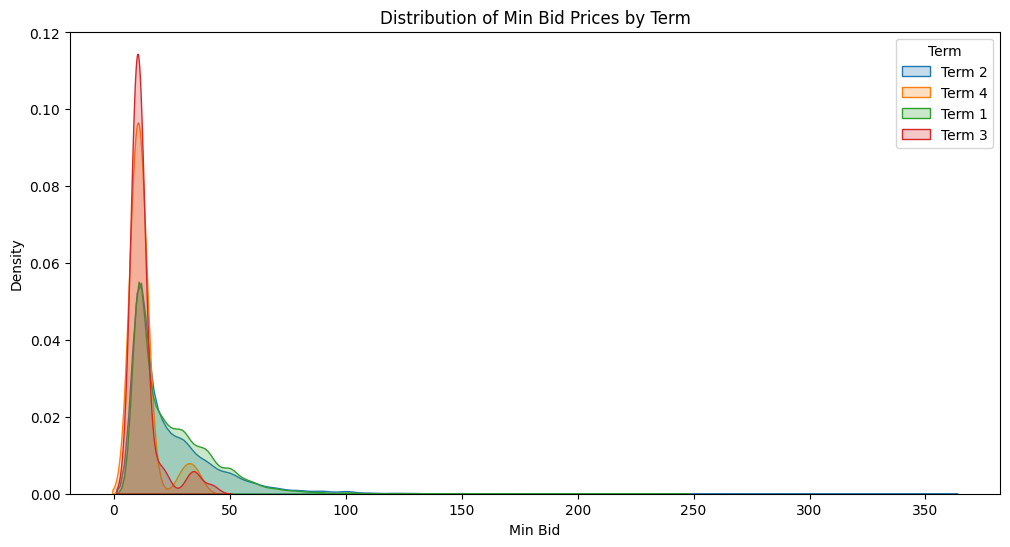

In [15]:
# KDE plot for Term
plt.figure(figsize=(12, 6))
for term in data['Term'].unique():
    sns.kdeplot(data[data['Term'] == term]['Min Bid'], label=f"Term {term}", fill=True)
plt.title("Distribution of Min Bid Prices by Term")
plt.xlabel("Min Bid")
plt.ylabel("Density")
plt.legend(title="Term")
plt.show()

Insights:
1. Term 2 has about 20% more records compared to Term 1, signalling that there are more classes on the second term.
2. With this increase in classes also shows an increase in average min bid prices and std, indicating more variability.
3. Term 3 and 4 have more points near the minimum bid price set by the school.

#### Round analysis against Min Bid

round_map = {
    '1': 1,
    '1A': 2,
    '1B': 3,
    '1C': 4,
    '2': 5,
    '2A': 6
}

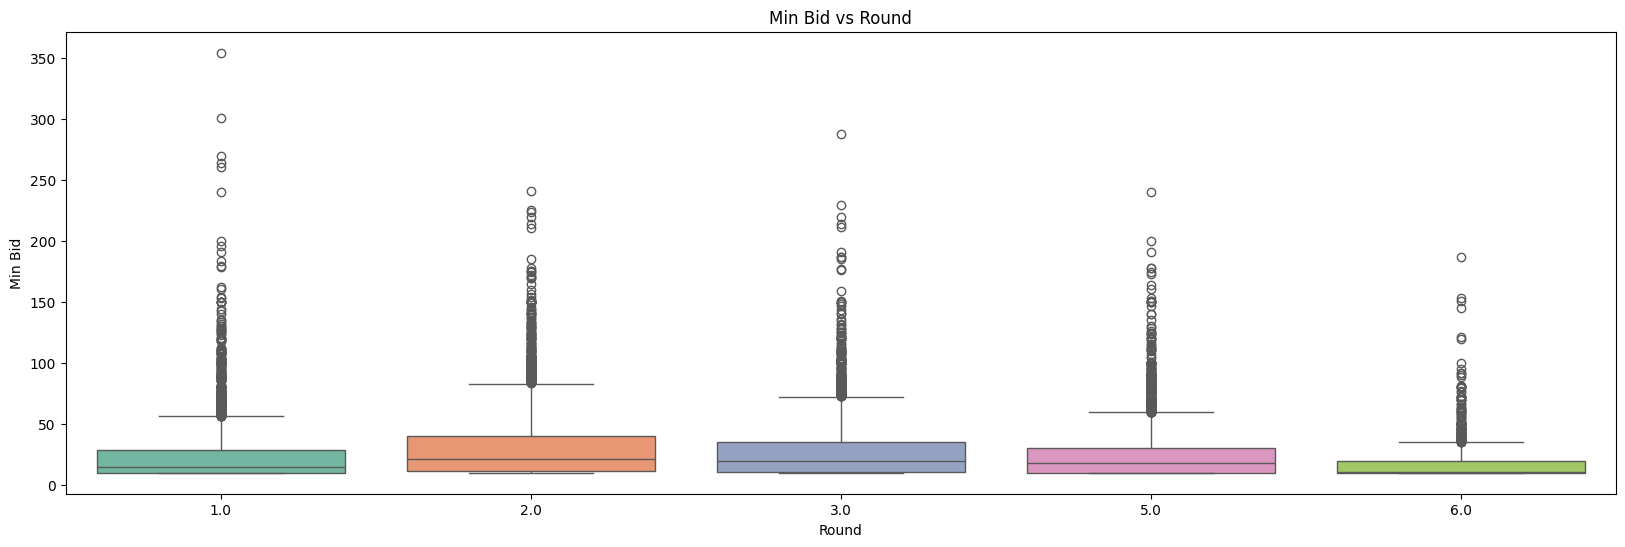

Numerical Statistics for Min Bid by Round:


,count,mean,std,min,25%,50%,75%,max
Round,,,,,,,,
1.0,9140.0,22.183849,18.629293,10.0,10.02,15.01,28.5425,354.58
2.0,9485.0,28.661141,22.071315,10.0,11.01,21.56,39.9900,241.14
3.0,5219.0,26.907423,22.221802,10.0,10.89,19.99,35.5750,288.00
5.0,6328.0,23.540687,18.503955,10.0,10.12,18.00,30.0000,239.91
6.0,1429.0,18.034619,15.591438,10.0,10.00,10.42,20.0100,186.82


In [16]:
# Boxplot for Round
plt.figure(figsize=(20, 6))
sns.boxplot(x=data['Round'], y=data['Min Bid'], palette='Set2', legend=False, hue=data['Round'])
plt.title("Min Bid vs Round")
plt.xlabel("Round")
plt.ylabel("Min Bid")
plt.show()

# Numerical statistics for Round
round_stats = data.groupby('Round')['Min Bid'].describe()
print("Numerical Statistics for Min Bid by Round:")
display(round_stats)

Insights:
1. Bidding in Round 2A is the cheapest. This is because round 2 starts when the term starts, making it very risky when securing bids. 
2. Round 1 is for those that have declared their major and track, making it cheaper when you aren't competing with people outside your declared major and track.
2. The most expensive bidding is in Round 1A, followed by 1B.

#### Window analysis against Min Bid

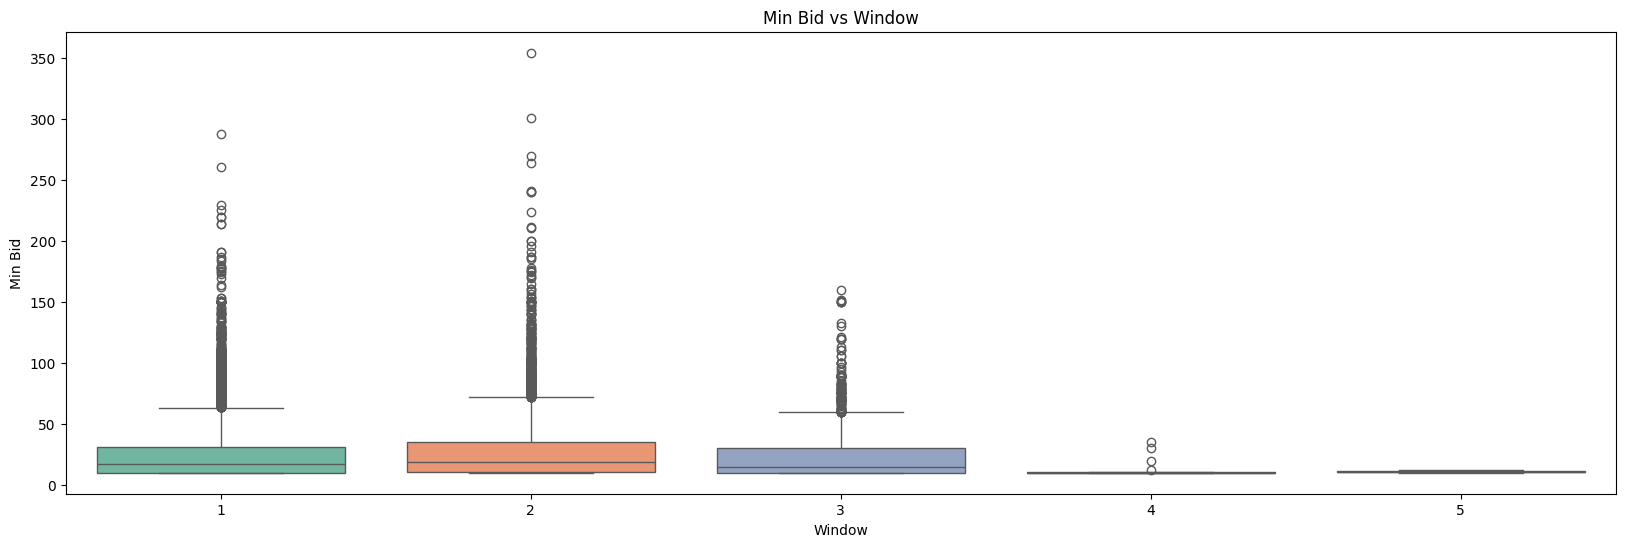

Numerical Statistics for Min Bid by Window:


,count,mean,std,min,25%,50%,75%,max
Window,,,,,,,,
1,17986.0,24.523427,19.629927,10.0,10.1100,17.335,31.50,288.00
2,11412.0,26.131739,21.818709,10.0,10.3975,18.880,35.00,354.58
3,2184.0,23.001131,19.020895,10.0,10.0100,15.000,30.00,160.00
4,17.0,13.402353,7.635998,10.0,10.0000,10.090,10.34,35.00
5,2.0,11.000000,1.414214,10.0,10.5000,11.000,11.50,12.00


In [17]:
# Boxplot for Window
plt.figure(figsize=(20, 6))
sns.boxplot(x=data['Window'], y=data['Min Bid'], palette='Set2', legend=False, hue=data['Window'])
plt.title("Min Bid vs Window")
plt.xlabel("Window")
plt.ylabel("Min Bid")
plt.show()

# Numerical statistics for Window
window_stats = data.groupby('Window')['Min Bid'].describe()
print("Numerical Statistics for Min Bid by Window:")
display(window_stats)

Insights:
1. Although Window 3 is cheaper than Window 1, there is lesser count so using intuition, it might not be significant to warrant bidding in Window 3.
2. However, bidding in Window 1 is cheaper compared to window 2, so it can be worthwhile to bid then.

#### Section analysis against Min Bid

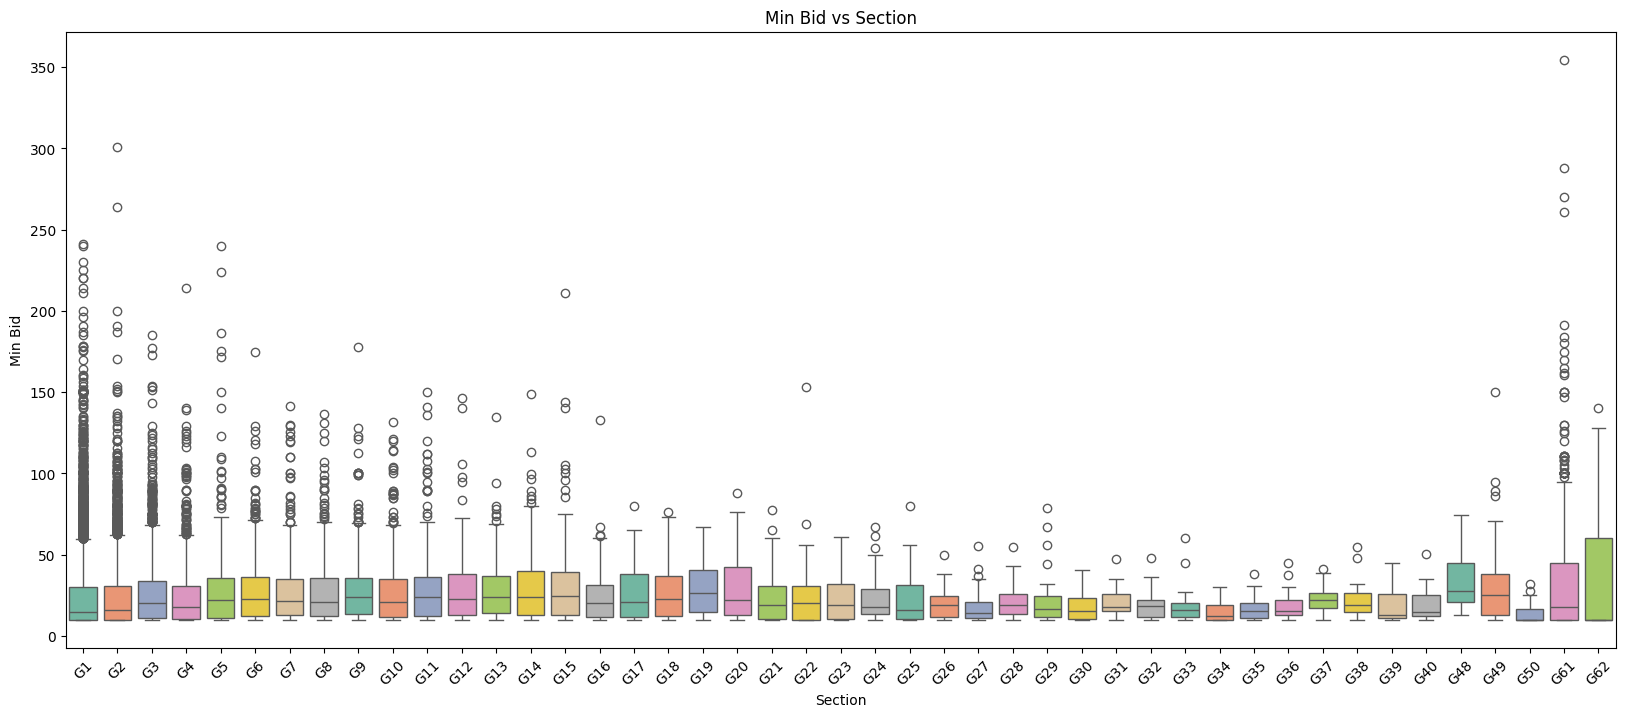

Numerical Statistics for Min Bid by Section:


,count,mean,std,min,25%,50%,75%,max
Section,,,,,,,,
G1,12283.0,23.724715,20.799828,10.00,10.0100,15.000,30.0000,241.14
G2,5469.0,24.270293,19.731025,10.00,10.0900,16.160,31.0000,300.99
G3,2859.0,25.633309,19.262499,10.00,10.9900,20.000,33.9900,185.00
G4,1986.0,23.937593,17.984115,10.00,10.2050,17.870,30.9875,214.32
G5,1105.0,26.824009,20.924622,10.00,11.1100,22.010,35.8900,240.00
G6,933.0,27.276517,19.122429,10.00,12.0000,22.550,36.0100,174.82
G7,895.0,26.401296,18.166087,10.00,12.8200,21.210,35.0000,141.28
G8,809.0,26.550532,18.156056,10.00,12.0000,20.950,35.3700,136.71
G9,759.0,27.303294,18.387260,10.00,13.3050,23.680,35.8950,177.70


In [18]:
import re

# Function for natural sorting
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

# Sort sections naturally
sorted_sections = sorted(data['Section'].unique(), key=natural_sort_key)
data['Section'] = pd.Categorical(data['Section'], ordered=True, categories=sorted_sections)

# Boxplot for Section
plt.figure(figsize=(20, 8))
sns.boxplot(x=data['Section'], y=data['Min Bid'], palette='Set2', legend=False, hue=data['Section'])
plt.title("Min Bid vs Section")
plt.xlabel("Section")
plt.ylabel("Min Bid")
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.show()

# Numerical statistics for Section
section_stats = data.groupby('Section')['Min Bid'].describe()
print("Numerical Statistics for Min Bid by Section:")
display(section_stats)

Insights:
1. Based on the correlation heatmap generated earlier, there is a slight correlation between section and instructor, indicating that some instructor are assigned the same section number. Thus having different bidding prices for sections.
2. Some highly specialised sections like G61 and G62 have higher than average bid prices.

#### Bidder count analysis against Min Bid

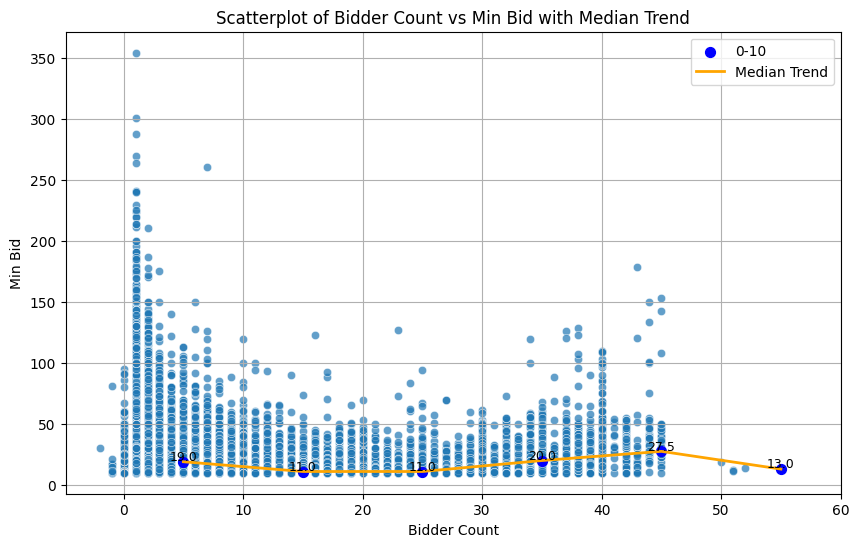

In [19]:
# Scatterplot with bins and annotations using median
plt.figure(figsize=(10, 6))
sns.scatterplot(x='BidderCount', y='Min Bid', data=data, alpha=0.7)

# Calculate and plot the median Min Bid for every 10-bidder interval
bin_ranges = np.arange(0, data['BidderCount'].max() + 10, 10)
median_min_bids = []
for lower, upper in zip(bin_ranges[:-1], bin_ranges[1:]):
    bin_data = data[(data['BidderCount'] >= lower) & (data['BidderCount'] < upper)]
    if not bin_data.empty:
        median_min_bid = bin_data['Min Bid'].median()
        median_min_bids.append((lower + 5, median_min_bid))
        plt.scatter(lower + 5, median_min_bid, color="blue", s=50, label=f"{lower}-{upper}" if lower == 0 else None)
        plt.text(lower + 5, median_min_bid + 1, f"{median_min_bid:.1f}", color="black", fontsize=9, ha="center")

# Connect median points to show the trend
median_points = np.array(median_min_bids)
plt.plot(median_points[:, 0], median_points[:, 1], color="orange", linewidth=2, label="Median Trend")

# Set plot details
plt.title("Scatterplot of Bidder Count vs Min Bid with Median Trend")
plt.xlabel("Bidder Count")
plt.ylabel("Min Bid")
plt.xticks(bin_ranges)
plt.grid(True)
plt.legend()
plt.show()


Insights:
1. Min Bid prices trend downwards slightly when there are more bidders
2. Not sure why it trends upwards towards the end

#### Vacanacy analysis against Min Bid

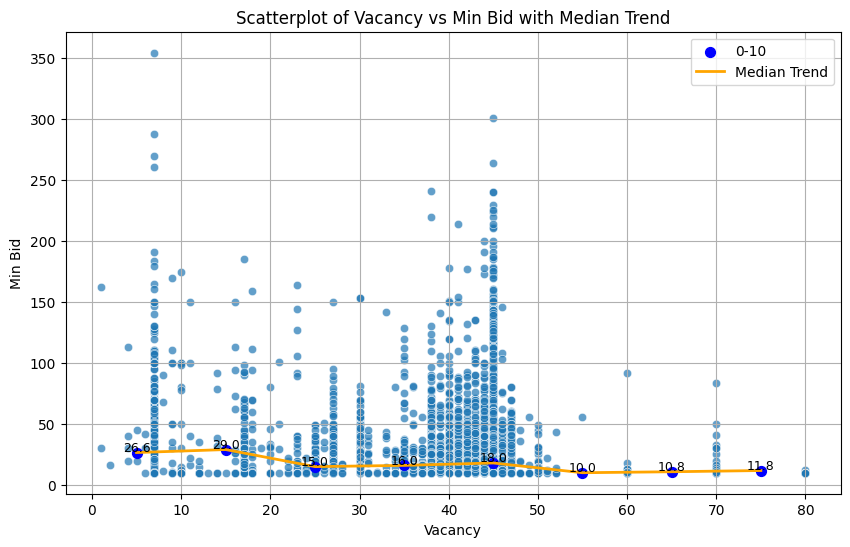

In [21]:
# Scatterplot with bins and annotations using median
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Vacancy', y='Min Bid', data=data, alpha=0.7)

# Calculate and plot the median Min Bid for every 10-bidder interval
bin_ranges = np.arange(0, data['Vacancy'].max() + 10, 10)
median_min_bids = []
for lower, upper in zip(bin_ranges[:-1], bin_ranges[1:]):
    bin_data = data[(data['Vacancy'] >= lower) & (data['Vacancy'] < upper)]
    if not bin_data.empty:
        median_min_bid = bin_data['Min Bid'].median()
        median_min_bids.append((lower + 5, median_min_bid))
        plt.scatter(lower + 5, median_min_bid, color="blue", s=50, label=f"{lower}-{upper}" if lower == 0 else None)
        plt.text(lower + 5, median_min_bid + 1, f"{median_min_bid:.1f}", color="black", fontsize=9, ha="center")

# Connect median points to show the trend
median_points = np.array(median_min_bids)
plt.plot(median_points[:, 0], median_points[:, 1], color="orange", linewidth=2, label="Median Trend")

# Set plot details
plt.title("Scatterplot of Vacancy vs Min Bid with Median Trend")
plt.xlabel("Vacancy")
plt.ylabel("Min Bid")
plt.xticks(bin_ranges)
plt.grid(True)
plt.legend()
plt.show()


Insights:
1. Similar to Biddercount, more vacancy leads to lower prices.


---
## 4. Further data cleaning

### Steps:
1. Remove redundant variable - Median Bid
2. Remove derived variable - CurrEnrolledCount

In [37]:
additional_columns_to_drop = ['Median Bid', 'CurrEnrolledCount']
data = data.drop(columns=additional_columns_to_drop)


---
## 5. Save data into CSV
    

In [38]:
# Save the transformed data to a CSV file
output_path = 'transformed_data.csv'
data.to_csv(output_path, index=False)
print(f"Data successfully saved to {output_path}")

Data successfully saved to transformed_data.csv
